## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Model Interpretability

In this exercise you'll use the [alibi](https://docs.seldon.io/projects/alibi/en/stable/) library to explain why some models make the predictions they do.

In [ ]:
# Uncomment to install the library

! pip install alibi

In [4]:
import sklearn
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

## Load and examine the Iris dataset

In [5]:
data = load_iris()

In [ ]:
print(data["DESCR"])
features = data["data"]
targets = data["target"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=0)

In [8]:
print(len(X_test))

38


## Build two different classifiers and train them on the Iris data

In [15]:
# Create 2 classifiers: a Random Forest model named "rf_clf", and a Linear SVM model named "svm_clf"
#
# Train them both on the training data.
# Use them to predict the test data - saving predictions as "y_rf_pred" and "y_svm_pred".
# You may want to use GridSearchCV to determine hyperparameters.

# YOUR CODE HERE
rf_clf = RandomForestClassifier().fit(X_train, y_train)
svm_clf = LinearSVC().fit(X_train, y_train)
y_rf_pred = rf_clf.predict(X_test)
y_svm_pred = svm_clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [16]:
assert len(y_rf_pred) == 38
assert isinstance(rf_clf, RandomForestClassifier) or isinstance(rf_clf, GridSearchCV)
assert len(y_svm_pred) == 38
assert isinstance(svm_clf, LinearSVC) or isinstance(svm_clf, GridSearchCV)

In [17]:
print(f"Random forest test set accuracy: {accuracy_score(y_test, y_rf_pred):0.3f}.")
print(f"SVM test set accuracy:           {accuracy_score(y_test, y_svm_pred):0.3f}.")

Random forest test set accuracy: 0.974.
SVM test set accuracy:           0.921.


## Get prediction explanations

In [18]:
# Since we used a Linear SVM, we can easily determine the coefficients for the features:

print("Each class gets a coefficient for each feature that helps us determine that feature's importance.")

print('\nSVM feature coefficients:')
if isinstance(svm_clf, LinearSVC):
    print(svm_clf.coef_)
elif isinstance(svm_clf, GridSearchCV):
    print(svm_clf.best_estimator_.coef_)

Each class gets a coefficient for each feature that helps us determine that feature's importance.

SVM feature coefficients:
[[ 0.21777872  0.39841912 -0.8330105  -0.4199274 ]
 [ 0.0265111  -0.80334454  0.39679878 -0.92348711]
 [-1.08584302 -0.78191595  1.61121419  1.50155951]]


Now let's look at how we can use explainers, namely the [AnchorTabular](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html#id3) explainer to understand why the models make the predictions they do.

In [19]:
from alibi.explainers import AnchorTabular

Alibi explainers follow a general structure of:

1. Initialize the explainer, providing a prediction function, and explainer specific parameters. `exp = Explainer(predict_func, param_1, param_2, ...)`
1. Fit the explainer to the training data (this step is explainer dependent) `exp.fit(train_data)`
1. Explain a given sample `exp.explain(sample)`

First, we reframe the prediction pipeline into a prediction function that we can use with the explainer:

In [20]:
rf_clf_func = lambda x: rf_clf.predict(x)
svm_clf_func = lambda x: svm_clf.predict(x)

Now we can instantiate the explainer using the prediction function and any parameters the explainer requires:

In [21]:
rf_explainer = AnchorTabular(rf_clf_func, data["feature_names"])
rf_explainer.fit(X_train)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None},
  'version': '0.6.2'}
)

In [22]:
svm_explainer = AnchorTabular(svm_clf_func, data["feature_names"])
svm_explainer.fit(X_train)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None},
  'version': '0.6.2'}
)

Once the explainer is set up, we can now use it to `.explain` samples! Pick a sample below to explain the two models' predictions.

In [31]:
# Change this value to choose a test sample
index_to_explain = 10


rf_explanation = rf_explainer.explain(X_test[index_to_explain])
svm_explanation = svm_explainer.explain(X_test[index_to_explain])

In [32]:
rf_explanation.anchor, rf_explanation.precision

(['petal length (cm) > 5.20'], 0.9924812030075187)

In [33]:
svm_explanation.anchor, svm_explanation.precision

(['petal length (cm) > 5.20', 'sepal width (cm) <= 2.80'], 0.9811320754716981)

Here we can see what the model's explanation for the classification of that sample is. You can see that even with our relatively interpretable model of Linear SVMs, these explainers can provide a more direct and intuitive explanation for why a sample was labeled the way it was.

Now that you've seen the general approach for these explainers, let's work on something a bit more complex. Now you'll have to create the models, the prediction function, and the explainers.

## Load the MNIST dataset

Explaining data from measured observations is simple enough. Now let's try explaining how images get labeled.

In [34]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.
x_test = x_test/255.

11501568/11490434 [==============================] - 0s 0us/step


### Add noise to the MNIST images

Because the nearly binary (black and white) nature of the MNIST images, the formation of superpixels is not representative of the type of behavior you would get from more complex, color images. To get closer to that type of behavior, we'll add noise to the images.

In [35]:
# Add noise to the MNIST images

x_train = x_train/2 + np.random.uniform(0, high=0.5, size=x_train.shape)
x_train = np.clip(x_train, 0, 1)

x_test = x_test/2 + np.random.uniform(0, high=0.5, size=x_test.shape)
x_test = np.clip(x_test, 0, 1)

In [36]:
sample_index = 12
sample = x_train[sample_index]

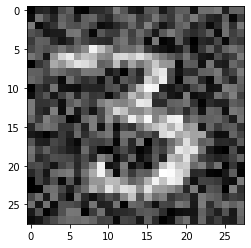

In [37]:
_ = plt.imshow(sample, cmap="gray")

## Build a CNN classifier and train it on MNIST

In [42]:
# Create a neural network model that should do well on the MNIST dataset and save it to mnist_nn
# Make the neural network sufficiently complex (at least 4 neural layers--max pooling and flatten
# layers do not count). A CNN is recommended over a fully-connected feedforward network.

# Save the neural network as "mnist_nn"
#
# *** Make sure you get at least 80% accuracy ***

# YOUR CODE HERE
layers = [
          tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
          tf.keras.layers.MaxPooling2D((2,2)),
          tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D((2,2)),
          tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
          tf.keras.layers.Flatten(),
          # i'm actually not sure about 100 being correct (read: optimal) here.
          tf.keras.layers.Dense(100, activation='relu'),
          tf.keras.layers.Dense(10, activation='softmax')
]
mnist_nn = tf.keras.Sequential(layers)

mnist_nn.summary()

mnist_nn.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mnist_nn.fit(x_train.reshape(-1, 28, 28 ,1), y_train,
             validation_data=(x_test.reshape(-1, 28, 28 ,1), y_test),
             epochs=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 128)         147584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [43]:
assert len(mnist_nn.layers) >= 4
assert mnist_nn.evaluate(x_test.reshape(-1, 28, 28 ,1), y_test)[1] > 0.8

313/313 [==============================] - 6s 19ms/step - loss: 0.0736 - accuracy: 0.9754


## Get explanations for the MNIST model's predictions

To work with images, we'll use the [AnchorImage](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html#id5) explainer. This explainer requires that we break up the image into "superpixels". We'll use the default 'slic' method to do so.

In [44]:
from alibi.explainers import AnchorImage

In [46]:
# Create an explainer object using AnchorImage that explains the mnist_nn model you created.
# Use the 'slic' method for as the segmentation function.
# Save the explainer as "mnist_explainer".

# YOUR CODE HERE
predict_fn = lambda x: mnist_nn.predict(x)
mnist_explainer = AnchorImage(predict_fn, segmentation_fn='slic', image_shape=(28,28,1))

In [47]:
assert isinstance(mnist_explainer, AnchorImage)

In [48]:
x_test.shape

(10000, 28, 28)

/usr/local/lib/python3.7/dist-packages/alibi/explainers/anchor_image.py:278: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.segmentation_fn(image_preproc)


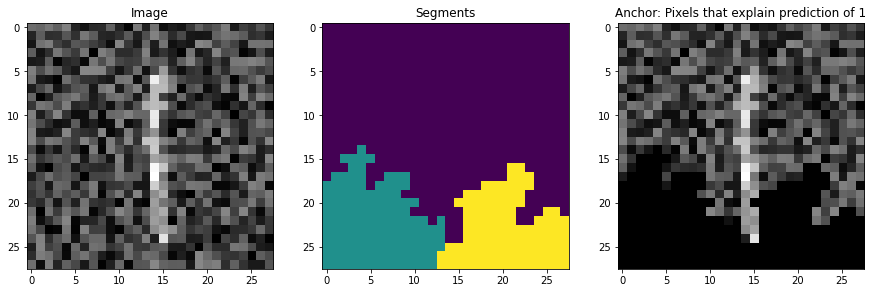

In [54]:
## Get an image, a prediction, and an explanation


# Change this number to try out different samples
image_index_to_explain = 203


# Get the image
image_to_explain = x_test[image_index_to_explain].reshape(28, 28, 1)

# Get the prediction
pred = mnist_nn.predict(image_to_explain.reshape(1, 28, 28, 1)).argmax()

# Get the explanation
mnist_image_explanation = mnist_explainer.explain(image_to_explain, threshold=0.95, p_sample=0.5)

# Show results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_to_explain[:,:,0], cmap="gray")
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(mnist_image_explanation.segments)
plt.title('Segments')

plt.subplot(1, 3, 3)
plt.imshow(mnist_image_explanation.anchor[:,:,0], cmap="gray")
_ = plt.title(f'Anchor: Pixels that explain prediction of {pred}')

### Impact of segmentation

One thing you may have noticed is that the explanations are heavily dependent on the superpixels we identify. 

You may want to alter some of the parameters of the 'slic' segmentation function to see how it impacts the segmentation, and thus the explaining anchor. Add the keyword argument below to your `AnchorImage` instantiation above, and adjust the values.  
`segmentation_kwargs={'n_segments': 15, 'compactness': 20, 'sigma': .5}`


## Feedback

In [55]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    # YOUR CODE HERE
    return 'N/A, thanks.'